In [58]:
import random
import torch
import d2l

### 根据带有噪声的线性模型构造一个人造数据集，我们使用线性模型参数$w = [2, -3.4]^T、 b = 4.2$和噪声项$Θ$来生成数据集及标签

X=torch.normal(mean=1,std=2,size=(3,4))
torch.normal()函数：返回一个张量；是从一个给定mean（均值），std（方差）的正态分布中抽取随机数。mean和std都是属于张量类型的；

In [67]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    # 要弄清楚matmul的用法，此处X是一个多维的向量，w是一维的，因此matmul的规则是将w变成列向量后得到结果（为一列向量），结果再
    # 转成一行向量，因此结果仍为一维，所以我们后面需要将y的shape重新转为一列
    y += torch.normal(0, 0.01, y.shape)
    # reshape(-1,1)是什么意思呢？难道有-1行？
    # 这里-1是指未设定行数，程序随机分配，所以这里-1表示任一正整数
    # 所以reshape(-1,1)表示（任意行，1列）
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [33]:
# features每一行都包含一个二维数据样本，labels每一行都包含一维标签值（一个标量）
print('features: ', features[0], 'labels: ', labels[0])

features:  tensor([-0.3788, -0.4205]) labels:  tensor([4.8805])


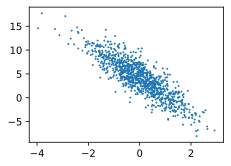

In [60]:
d2l.set_figsize()
# 第三个参数1是指定画出的散点圆的大小
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

In [61]:
# 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    num_examples = len(labels)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    print()

tensor([[ 0.2781,  1.6100],
        [ 1.1466,  0.3470],
        [ 0.5646, -0.3817],
        [-1.2550, -0.2872],
        [-0.2104, -0.9169],
        [ 1.4334,  0.7944],
        [ 0.6747, -0.5671],
        [ 2.1258, -0.0027],
        [ 0.1397, -0.4927],
        [-0.7693, -1.1521]]) tensor([[-0.7256],
        [ 5.3201],
        [ 6.6172],
        [ 2.6756],
        [ 6.8989],
        [ 4.3840],
        [ 7.4702],
        [ 8.4714],
        [ 6.1664],
        [ 6.5805]])

tensor([[-1.0128,  0.6811],
        [-0.0663,  0.0598],
        [-0.9043, -2.0513],
        [ 1.2627,  0.1365],
        [ 0.0960,  1.6731],
        [ 0.9596,  2.5668],
        [-1.0726,  1.2244],
        [-0.1422,  0.8269],
        [-1.9845, -0.1540],
        [ 0.3221,  0.4360]]) tensor([[-0.1463],
        [ 3.8559],
        [ 9.3574],
        [ 6.2591],
        [-1.2924],
        [-2.6197],
        [-2.1217],
        [ 1.1008],
        [ 0.7535],
        [ 3.3549]])

tensor([[ 1.2718, -0.2985],
        [ 0.9250, -1.0391]

In [62]:
# 定义初始化模型参数
w = torch.normal(0, 1, (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [68]:
# 定义模型
def linear(X, w, b):
    return torch.matmul(X, w) + b

In [70]:
# 定义损失函数
def squared_loss(y_hat, y):
    # 计算过程当中y和y_hat可能一个是行向量，一个是列向量，为了统一起见，我们将其reshape一下
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [72]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        # params当中是w和b
        for param in params:
            param -= lr * param.grad / batch_size
            # 将梯度清零，防止梯度与上一次求得的梯度相关
            param.grad.zero_()

In [79]:
# 训练过程
lr = 0.03
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        loss = squared_loss(linear(X, w, b), y)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = squared_loss(linear(features, w, b), labels)
        print(f"epoch:{epoch}, train_loss:{float(train_l.mean())}")

epoch:0, train_loss:4.926513065584004e-05
epoch:1, train_loss:4.933472882839851e-05
epoch:2, train_loss:4.932213414576836e-05


In [81]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f"w的估计误差：{true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差：{true_b - b}")

w的估计误差：tensor([0.0003, 0.0009], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0003], grad_fn=<RsubBackward1>)


### 线性回归的简洁实现
#### 通过使用深度学习框架来简洁地实现线性回归模型，生成数据集

In [90]:
import torch
from torch.utils import data
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [92]:
# 通过调用现有的框架来读取数据
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-1.5351, -0.5397],
         [ 0.4787,  0.0714],
         [-1.3235, -0.0194],
         [ 2.4242, -0.0741],
         [-0.0653,  0.9456],
         [ 0.0112, -0.7864],
         [ 0.0671, -0.9524],
         [ 0.5227,  0.2221],
         [ 0.1268, -0.3513],
         [ 0.2352,  0.3484]]),
 tensor([[2.9639],
         [4.9016],
         [1.6118],
         [9.3041],
         [0.8543],
         [6.8906],
         [7.5639],
         [4.4833],
         [5.6463],
         [3.4836]])]

In [93]:
# 使用框架的预定义好的层
from torch import nn
# 因为输入的维度是2，输出的维度是1
net = nn.Sequential(nn.Linear(2, 1))
# 均值为0，方差为0.01的正态分布
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [94]:
# 计算均方误差使用的是MSELoss类，也称为L2平方范数
loss = nn.MSELoss()
# 实例化SGD实例
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [99]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        # 先把梯度清零
        trainer.zero_grad()
        l.backward()
        # 进行模型的更新
        trainer.step()
    l = loss(net(features), labels)
    print(f"epoch:{epoch}, train_loss:{l:f}")

epoch:0, train_loss:0.000320
epoch:1, train_loss:0.000105
epoch:2, train_loss:0.000107
